In [1]:
##Importing packages we need##

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.cm import get_cmap
from matplotlib.colors import LinearSegmentedColormap
import metpy.calc as mpcalc
from metpy.units import units
from numpy import *
import xarray as xr
from netCDF4 import Dataset, num2date
import math
import pygrib
import cdsapi
from datetime import datetime, timedelta
import numpy as np
import metpy as mp
import warnings
warnings.filterwarnings("ignore")

print("Done importing modules")

Done importing modules


In [2]:
#%pip install cdsapi

# ##Extract all the 3-hr ERA5 data from 1950-2022 from the petalibrary##

# #Sort all the ERA5 files#
# DIR = '/pl/active/ATOC_SynopticMet/Michael/ERA5_annualdata/era5_colorado_3hr*'
# filenames = sorted([f for f in glob.glob(DIR)])

# #Load and concatenate files along time dimension
# ds_comb = xr.open_mfdataset(filenames, concat_dim = 'Time', combine = 'nested', parallel=True)

# # Save the combined dataset to a new NetCDF file
# output_file = '/projects/zami4053/Synoptic_Research/ERA5_fullTP3hr'
# ds_comb.to_netcdf(output_file)

# print(f'Combined dataset saved to {output_file}')

# df_3hr = xr.open_dataset("ERA5_fullTP3hr")
# df_3hr

In [3]:
##Declare time, level, and lat/lon boundaries here##

startdate = '12/22/22 00:00'    #Must be in this format 'MM/DD/YY HH:MM'  '12/22/22 00:00' 
latN = 90
latS = 0
lonW = 180    #Must be in degrees E (The western hemisphere is captured between 180 and 360 degrees east)
lonE = 359
date = datetime.strptime(startdate,'%m/%d/%y %H:%M')
level = 850    #What level do we want to look at FLF on

In [4]:
##Download ERA5 data using CDS-API, only run once for data##

filestr1 = 'synoptic_'+date.strftime('%Y')+date.strftime('%m')+date.strftime('%d')+'_'+date.strftime('%H')+'00_850.nc'     # you can change these filenames as you see fit
print(filestr1)    

filestr2 = 'synoptic_'+date.strftime('%Y')+date.strftime('%m')+date.strftime('%d')+'_'+date.strftime('%H')+'00_sfc.nc'     # you can change these filenames as you see fit
print(filestr2) 

# #Multiple pressure levels#
# c1 = cdsapi.Client()
# c1.retrieve('reanalysis-era5-pressure-levels', {
#     'product_type': 'reanalysis',
#     'variable': ['geopotential','temperature','u_component_of_wind', 'v_component_of_wind','vertical_velocity'],
#     'pressure_level': '850',
#     'year': date.strftime('%Y'),         #substitutes the year based off the startdate in the above cell
#     'month': date.strftime('%m'),        #substitutes the month based off the startdate in the above cell
#     'day': date.strftime('%d'),          #substitutes the year based off the startdate in the above cell
#     'time': date.strftime('%H:%M'),      #substitutes the time based off the startdate in the above above
#     'format': 'netcdf',
# }, filestr1)

# ##Single surface level only##
# c2 = cdsapi.Client()
# c2.retrieve('reanalysis-era5-single-levels', {
#     'product_type': 'reanalysis',
#     'variable': ['geopotential', 'vertical_velocity', '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_dewpoint_temperature',
#             '2m_temperature', 'mean_sea_level_pressure', 'surface_pressure'],
#     'year': date.strftime('%Y'),         #substitutes the year based off the startdate in the above cell
#     'month': date.strftime('%m'),        #substitutes the month based off the startdate in the above cell
#     'day': date.strftime('%d'),          #substitutes the year based off the startdate in the above cell
#     'time': date.strftime('%H:%M'),      #substitutes the time based off the startdate in the above above
#     'format': 'netcdf',
# }, filestr2)

synoptic_20221222_0000_850.nc
synoptic_20221222_0000_sfc.nc


In [5]:
##Load in the datasets and read in variables and cords##

#Acquire data#
ds = xr.open_dataset(str('ERA5_data/'+filestr1)).metpy.parse_cf()  #the filestring goes here
ds_sfc = xr.open_dataset(str('ERA5_data/'+filestr2)).metpy.parse_cf()

#This is for the 850 level#
uwnd = ds.u.metpy.sel(time=date,latitude=slice(latN,latS),longitude=slice(lonW,lonE))
vwnd = ds.v.metpy.sel(time=date,latitude=slice(latN,latS),longitude=slice(lonW,lonE))
tmpk = ds.t.metpy.sel(time=date,latitude=slice(latN,latS),longitude=slice(lonW,lonE))
geop = ds.z.metpy.sel(time=date,latitude=slice(latN,latS),longitude=slice(lonW,lonE))
hght = geop/9.81 * units.meters   # need to divide the geopotential by gravity to get the geopotential height

#This is for the surface level#
dew_2m = ds_sfc.d2m.metpy.sel(time=date,latitude=slice(latN,latS),longitude=slice(lonW,lonE))
uwnd_10m = ds_sfc.u10.metpy.sel(time=date,latitude=slice(latN,latS),longitude=slice(lonW,lonE))
vwnd_10m = ds_sfc.v10.metpy.sel(time=date,latitude=slice(latN,latS),longitude=slice(lonW,lonE))
tmpk_2m = ds_sfc.t2m.metpy.sel(time=date,latitude=slice(latN,latS),longitude=slice(lonW,lonE))
mslp = ds_sfc.msl.metpy.sel(time=date,latitude=slice(latN,latS),longitude=slice(lonW,lonE))
sfc_p = ds_sfc.sp.metpy.sel(time=date,latitude=slice(latN,latS),longitude=slice(lonW,lonE))

#Extract Coordinates#
lats = ds.latitude.metpy.sel(latitude=slice(latN,latS))
lons = ds.longitude.metpy.sel(longitude=slice(lonW,lonE))
lons_2D, lats_2D = meshgrid(lons,lats)
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

In [6]:
uwnd

<xarray.DataArray 'u' (latitude: 361, longitude: 717)>
[258837 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 180.0 180.2 180.5 180.8 ... 358.5 358.8 359.0
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 0.75 0.5 0.25 0.0
    time       datetime64[ns] 2022-12-22
    metpy_crs  object Projection: latitude_longitude
Attributes:
    units:          m s**-1
    long_name:      U component of wind
    standard_name:  eastward_wind

In [7]:
##Apply a spatial smoother to the variables so that synoptic-scale signals can be more readily observed (25)##

smoothing_var = 15

#850 variables#
uwnd = mpcalc.smooth_gaussian(uwnd,smoothing_var)
vwnd = mpcalc.smooth_gaussian(vwnd,smoothing_var)
tmpk = mpcalc.smooth_gaussian(tmpk,smoothing_var)
hght = mpcalc.smooth_gaussian(hght,smoothing_var)
#hght = mpcalc.smooth_gaussian(hght,25)

#Surface variables#
dew_2m = mpcalc.smooth_gaussian(dew_2m,smoothing_var)
uwnd_10m = mpcalc.smooth_gaussian(uwnd_10m,smoothing_var)
vwnd_10m = mpcalc.smooth_gaussian(vwnd_10m,smoothing_var)
tmpk_2m = mpcalc.smooth_gaussian(tmpk_2m,smoothing_var)
mslp = mpcalc.smooth_gaussian(mslp,smoothing_var)
sfc_p = mpcalc.smooth_gaussian(sfc_p,smoothing_var)

In [8]:
##Calculate additional variables to plot##

#Upper level variables at 850 hPa#
coriolis = mpcalc.coriolis_parameter(lats_2D*units.degrees)
theta = mpcalc.potential_temperature(level * units.hPa, tmpk)
geo = mpcalc.geostrophic_wind(hght,dx=dx,dy=dy,latitude=lats_2D*units.degrees)   #Geostrophic wind
age = mpcalc.ageostrophic_wind(hght,uwnd,vwnd,dx=dx,dy=dy,latitude=lats)    #Ageostrophic wind

ug, vg = geo[0], geo[1]
ua, va = age[0], age[1]

#Surface level variables#
thetaE = mpcalc.equivalent_potential_temperature(sfc_p, tmpk_2m, dew_2m) 
geo_10m = mpcalc.geostrophic_wind(hght,dx=dx,dy=dy,latitude=lats_2D*units.degrees)   #Geostrophic wind
age_10m = mpcalc.ageostrophic_wind(hght,uwnd,vwnd,dx=dx,dy=dy,latitude=lats)    #Ageostrophic wind

ug_10m, vg_10m = geo_10m[0], geo_10m[1]
ua_10m, va_10m = age_10m[0], age_10m[1]

In [9]:
thetaE

Magnitude,[[251.48507690429688 251.48486328125 251.4844512939453 ... 252.03912353515625 252.03919982910156 252.0392303466797] [251.45921325683594 251.45887756347656 251.45811462402344 ... 252.17739868164062 252.17713928222656 252.17698669433594] [251.41912841796875 251.41831970214844 251.4168701171875 ... 252.47189331054688 252.47080993652344 252.47023010253906] ... [352.1624755859375 352.1468811035156 352.1074523925781 ... 351.73077392578125 351.6776428222656 351.6368713378906] [352.4460144042969 352.4268798828125 352.38037109375 ... 351.6816711425781 351.6168212890625 351.5685729980469] [352.6043395996094 352.5826721191406 352.5311279296875 ... 351.66168212890625 351.58935546875 351.53643798828125]]
Units,kelvin


In [10]:
##Calculate Front Locator Function (FLF) using ThetaE##

#Step 1- grad(0e) [vectors]#
d0_dy, d0_dx = mpcalc.gradient(thetaE, deltas=(dy, dx)) 

#Step 2- magnitude of Step 1 [scalar]#
mag_grad_thetaE = np.sqrt((d0_dx**2) + (d0_dy**2))  #|grad(0e)|

#Step 3- grad of Step 2 [vectors]#
grad_step2_y, grad_step2_x= mpcalc.gradient(mag_grad_thetaE, deltas=(dy, dx))

#Step 4- divergence of Step 3 [scalar]#
div_step4 = mpcalc.divergence(grad_step2_x, grad_step2_y, dx=dx, dy=dy)

In [11]:
##Qn and Qs Partioning of Step 3 with scaling##

qx = grad_step2_x.copy()
qy = grad_step2_y.copy()
denominator = ((d0_dx) * (d0_dx)) + ((d0_dy) * (d0_dy))

#Qn Vector Components#
Qn_x = (((qx) * (d0_dx) * (d0_dx)) + ((qy) * (d0_dy) * (d0_dx))) / (denominator)  #i component
Qn_y = (((qx) * (d0_dx) * (d0_dy)) + ((qy) * (d0_dy) * (d0_dy))) / (denominator)  #j component
Qn_x_convert = Qn_x * 1e9
Qn_y_convert = Qn_y * 1e9
Qn_low = Qn_x + Qn_y
Qn = Qn_low * 1e10

#Qs Vector Components#
Qs_x = (((qx) * (d0_dy) * (d0_dy)) - ((qy) * (d0_dx) * (d0_dy))) / (denominator)  #i component
Qs_y = ((-1 * (qx) * (d0_dy) * (d0_dx)) + ((qy) * (d0_dx) * (d0_dx))) / (denominator)  #j component
Qs_x_convert = Qs_x * 1e9
Qs_y_convert = Qs_y * 1e9
Qs_low = Qs_x + Qs_y
Qs = Qs_low * 1e10

#Redo step 4 with Qn divergence#
div_step4_Qn = mpcalc.divergence(Qn_x, Qn_y, dx=dx, dy=dy)
div_step4_Qn_convert = div_step4_Qn * 1e12  #What we need

#Also do with Qs for completeness#
div_step4_Qs = mpcalc.divergence(Qs_x, Qs_y, dx=dx, dy=dy)
div_step4_Qs_convert = div_step4_Qs * 1e12


In [12]:
##Conversion factors and Fixing Units##

d0_dx_convert = d0_dx * 1e5  #s1
d0_dy_convert = d0_dy * 1e5  #s1
mag_grad_thetaE_convert = mag_grad_thetaE * 1e5  #s2
grad_step2_x_convert = grad_step2_x * 1e9  #s3
grad_step2_y_convert = grad_step2_y * 1e9  #s3
div_step4_convert = div_step4 * 1e12  #s4

np.nanmin(div_step4_Qn_convert), np.nanmax(div_step4_Qn_convert)

(-5.001593392028515 <Unit('kelvin / meter ** 3')>,
 4.381699399080529 <Unit('kelvin / meter ** 3')>)

In [13]:
##Trying some thresholding for div step 4##

#Set a threshold value#
testy = div_step4_convert.copy()
threshold_value = -0.005 * units('kelvin/meter^3')  
testy_numpy_array = testy.magnitude 

#Filter out array based on that value#
filtered_array = testy_numpy_array.copy()
filtered_array[filtered_array >= threshold_value.magnitude] = np.nan

#Count the amount of nans#
nan_count = np.isnan(filtered_array).sum()
print("FLF Full Nan Count: ", nan_count)
print("Total array length: ",len(filtered_array.ravel()))

print('*' * 50)

##Trying some thresholding for div step 4 only Qn#
testy2 = div_step4_Qn_convert.copy()
threshold_value2 = -0.005 * units('kelvin/meter^3')  
testy_numpy_array2 = testy2.magnitude 

#Filter out array based on that value#
filtered_array2 = testy_numpy_array2.copy()
filtered_array2[filtered_array2 >= threshold_value2.magnitude] = np.nan

#Count the amount of nans#
nan_count2 = np.isnan(filtered_array2).sum()
print("FLF Qn Nan Count: ", nan_count2)
print("Total array length: ", len(filtered_array2.ravel()))



FLF Full Nan Count:  219998
Total array length:  258837
**************************************************
FLF Qn Nan Count:  224837
Total array length:  258837


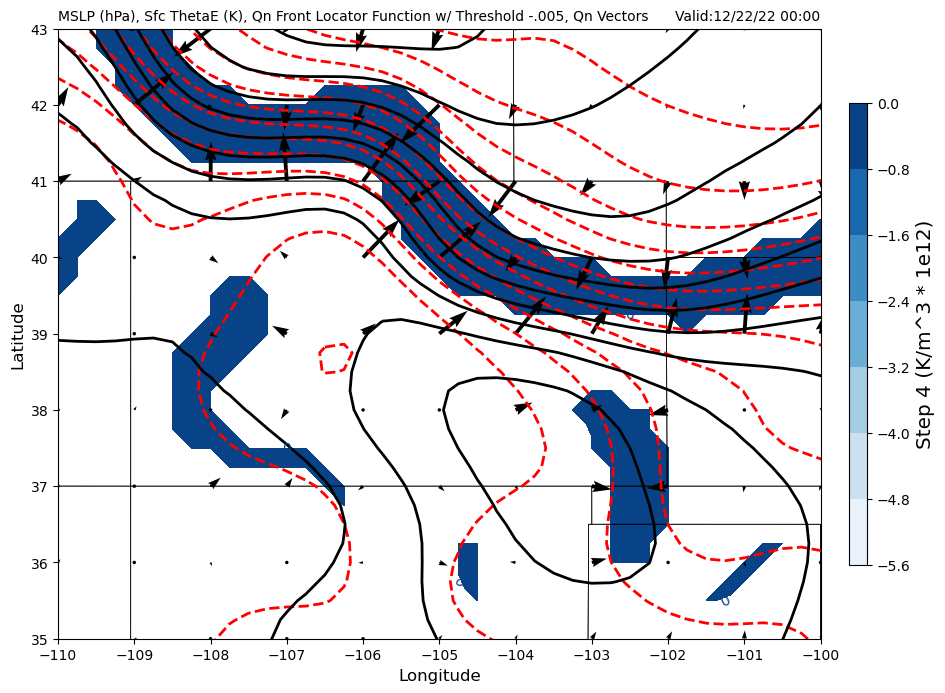

In [14]:
##Create the plot for FLF##

#Set up the projection that will be used#
mapcrs = ccrs.LambertConformal(central_longitude=-55, central_latitude=45, standard_parallels=(33, 45)) 
mapcrs = ccrs.PlateCarree()

#Set up the projection of the data; if lat/lon then PlateCarree is what you want#
datacrs = ccrs.PlateCarree()

#Start the figure and create plot axes with proper projection#
fig = plt.figure(1, figsize=(12, 10)) 
ax = plt.subplot(111, projection=mapcrs) 
ax.set_extent([-110, -100, 35, 43], ccrs.PlateCarree())  #-110, -100, 35, 43 | -110, -60, 20, 60

#Add geopolitical boundaries for map reference#
ax.add_feature(cfeature.LAND, facecolor="white") 
countries = NaturalEarthFeature(category="cultural", scale="110m", facecolor="none", name="admin_0_boundary_lines_land") 
ax.add_feature(countries, linewidth=0.5, edgecolor="black") 
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5) 
ax.coastlines('50m', linewidth=0.8)

#Set up contour and fill intervals#
# hght_levels  = arange(1000,7020,30) 
# theta_levels = arange(250,400,4)
thetaE_levels  = arange(250,400,4)
mslp_levels = arange(950,1050,4) 
div_step4_levels = arange(-2,0.5,0.5) 
#Qn_levels = arange(-7.0,3.5,0.5) 

#Plot the variables#
#hght_contours = plt.contour(lons, lats, hght, levels=hght_levels, colors="k", linestyles='solid',linewidths=2.0, transform=ccrs.PlateCarree()) 
#theta_contours = plt.contour(lons, lats, theta, levels=theta_levels, colors="green", linestyles='dashed',linewidths=2.0, transform=ccrs.PlateCarree()) 
thetaE_contours = plt.contour(lons, lats, thetaE, levels=thetaE_levels, colors="red", linestyles='dashed',linewidths=2.0, transform=ccrs.PlateCarree())
mslp_contours = plt.contour(lons, lats, mslp/100., levels=mslp_levels, colors="black", linestyles='solid',linewidths=2.0, transform=ccrs.PlateCarree()) 
#mag_thetaE_fcontours = plt.contourf(lons, lats, mag_grad_thetaE_convert, cmap='Reds', alpha=1, transform=ccrs.PlateCarree())
#div_step4_fcontours = plt.contourf(lons, lats, filtered_array, cmap='Blues', alpha=1, transform=ccrs.PlateCarree())
div_step4_Qn_convert_fcontours = plt.contourf(lons, lats, filtered_array2, cmap='Blues', alpha=1, transform=ccrs.PlateCarree())

#Plot wind barbs for sfc
step = 4
uwndbrb = (uwnd_10m.values * units.meter / units.second).to('kt')  #use uwnd and vwnd for 850
vwndbrb = (vwnd_10m.values * units.meter / units.second).to('kt')
#ax.barbs(lons[::step], lats[::step], uwndbrb.m[::step,::step], vwndbrb.m[::step,::step], pivot='middle',color='k',transform=datacrs)

#Plot the vectors for the various steps
#ax.quiver(lons[::step], lats[::step], d0_dx_convert[::step,::step], d0_dy_convert[::step,::step], pivot='middle', transform=ccrs.PlateCarree(), scale=300, width=0.005) #step 1
#ax.quiver(lons[::step], lats[::step], grad_step2_x_convert[::step,::step], grad_step2_y_convert[::step,::step], pivot='middle', transform=ccrs.PlateCarree(), scale=20, width=0.005) #step 1
ax.quiver(lons[::step], lats[::step], Qn_x_convert[::step,::step], Qn_y_convert[::step,::step], pivot='tail', transform=ccrs.PlateCarree(), scale=20, width=0.005, color='black') #step 3 3
#ax.quiver(lons[::step], lats[::step], Qs_x_convert[::step,::step], Qs_y_convert[::step,::step], pivot='tail', transform=ccrs.PlateCarree(), scale=12, width=0.005, color='black') #step 3
#ax.quiver(lons[::step], lats[::step], Qs[::step,::step], Qn[::step,::step], pivot='tail', transform=ccrs.PlateCarree(), scale=300, width=0.005, color='deeppink') #step 3 full

#Colorbar and contour labels#
cb = fig.colorbar(div_step4_Qn_convert_fcontours, orientation='vertical', pad=0.03, extendrect=True, aspect=25, shrink=0.6)
cb.set_label('Step 4 (K/m^3 * 1e12)', size='x-large')
plt.clabel(div_step4_Qn_convert_fcontours, fmt='%d') 

#Plot the longitude and latitude#
ax.set_xticks(range(-110, -99, 1), crs=ccrs.PlateCarree())
ax.set_yticks(range(35, 44, 1), crs=ccrs.PlateCarree())
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
plt.title('MSLP (hPa), Sfc ThetaE (K), Qn Front Locator Function w/ Threshold -.005, Qn Vectors', loc='left', fontsize=10) #r'$\nabla$'+'|'+r'$\nabla$'+'(ThetaE)| Vectors
plt.title('Valid:'+startdate, loc='right', fontsize=10)

#Save figure#
fname_date = date.strftime('%y%m%d')+'_'+date.strftime('%H%M')
#fig.savefig('fgen_total_'+fname_date+'.png',facecolor='white',dpi=150)

plt.show()

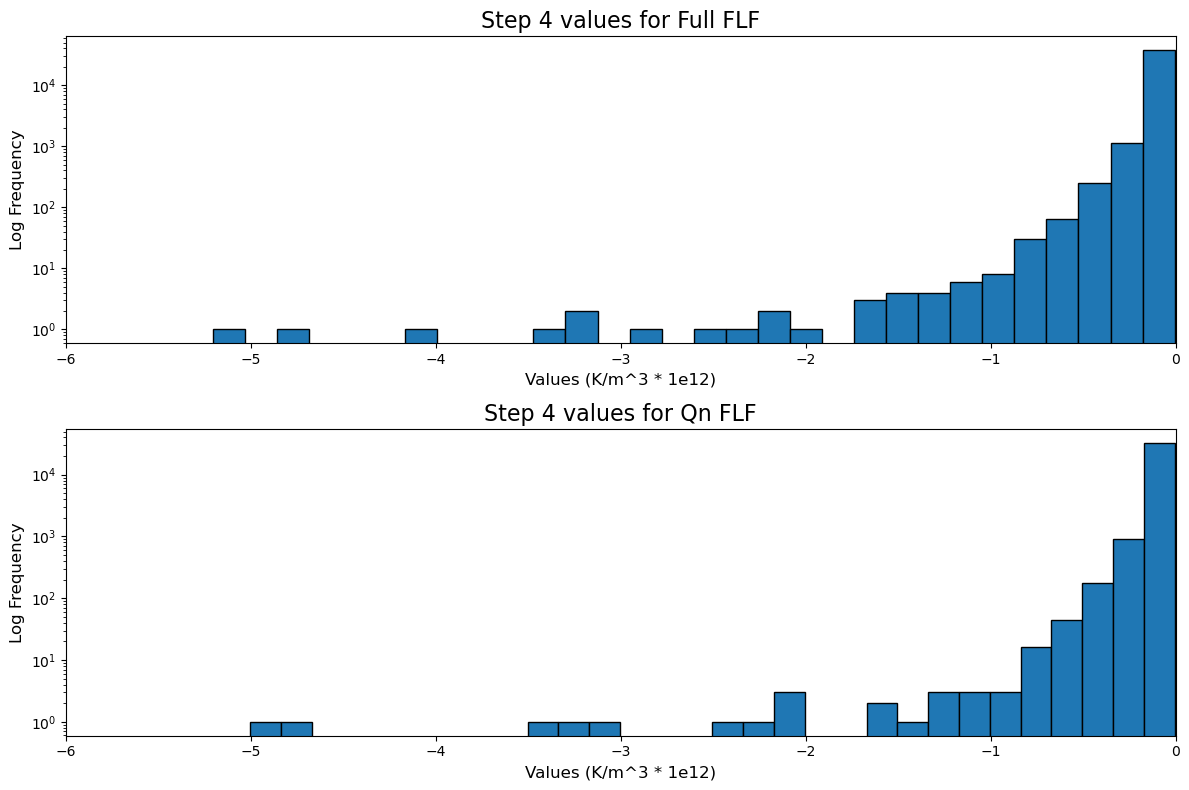

In [15]:
##Plot a histogram of all the step 4 divergence values for thresholding##

step4_full_hist = filtered_array.copy().ravel()
step4_Qn_hist = filtered_array2.copy().ravel()

#Plotting time#
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

#Full step 4
axs[0].hist(step4_full_hist, bins=30, edgecolor='black')
axs[0].set_title('Step 4 values for Full FLF', fontsize=16)
axs[0].set_xlabel('Values (K/m^3 * 1e12)', fontsize=12)
axs[0].set_ylabel('Log Frequency', fontsize=12)
#x_values = np.arange(-1.0, 1.0, step=0.1)
axs[0].set_xlim([-6.0,0])  #-0.5
axs[0].set_yscale('log')

#Qn step 4
axs[1].hist(step4_Qn_hist, bins=30, edgecolor='black')
axs[1].set_title('Step 4 values for Qn FLF', fontsize=16)
axs[1].set_xlabel('Values (K/m^3 * 1e12)', fontsize=12)
axs[1].set_ylabel('Log Frequency', fontsize=12)
axs[1].set_xlim([-6.0,0])
axs[1].set_yscale('log')

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()


In [16]:
##We want to extract the FLF values for the Eastern CO domain##

#Convert to xr and subset for Eastern CO
FLF_xr = xr.DataArray(filtered_array2, dims=['latitude', 'longitude'], )
FLF_ECO = FLF_xr[196:213, 299:313] 

#Assign lat and lon coords
lon_assign = np.array([-105.25, -105., -104.75, -104.5, -104.25, -104., -103.75, -103.5,
                       -103.25, -103., -102.75, -102.5, -102.25, -102.])
lat_assign = np.array([41., 40.75, 40.5, 40.25, 40., 39.75, 39.5, 39.25, 39., 38.75,
                       38.5, 38.25, 38., 37.75, 37.5, 37.25, 37.])

FLF_ECO = FLF_ECO.assign_coords(latitude=("latitude", lat_assign), longitude=("longitude", lon_assign))

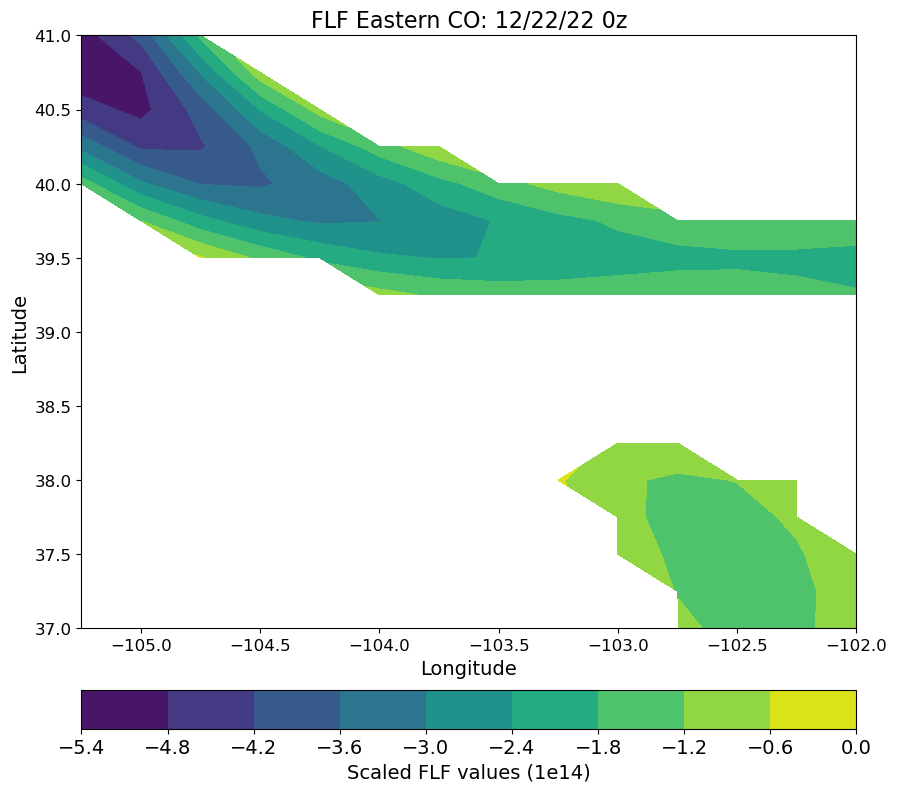

<xarray.DataArray ()>
array(173.56294115)

In [17]:
##Plot what the FLF would look like for Eastern CO and sum up values##

#Plotting##
fig, ax = plt.subplots(1, figsize=(10,10))
cf_FLF = plt.contourf(FLF_ECO.longitude, FLF_ECO.latitude, FLF_ECO*100, cmap='viridis', alpha=1)
cbar = plt.colorbar(cf_FLF, orientation='horizontal', pad=0.08)  #Frequency of Cold Front Flags

ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.set_title('FLF Eastern CO: 12/22/22 0z', fontsize=16)
ax.tick_params(labelsize=12)
cbar.set_label(label='Scaled FLF values (1e14)', size=14)
cbar.ax.tick_params(labelsize=14)

plt.show()

#Now take abs value and sum up FLF values for timestep#
FLF_abs = abs(FLF_ECO*100).sum()
FLF_abs

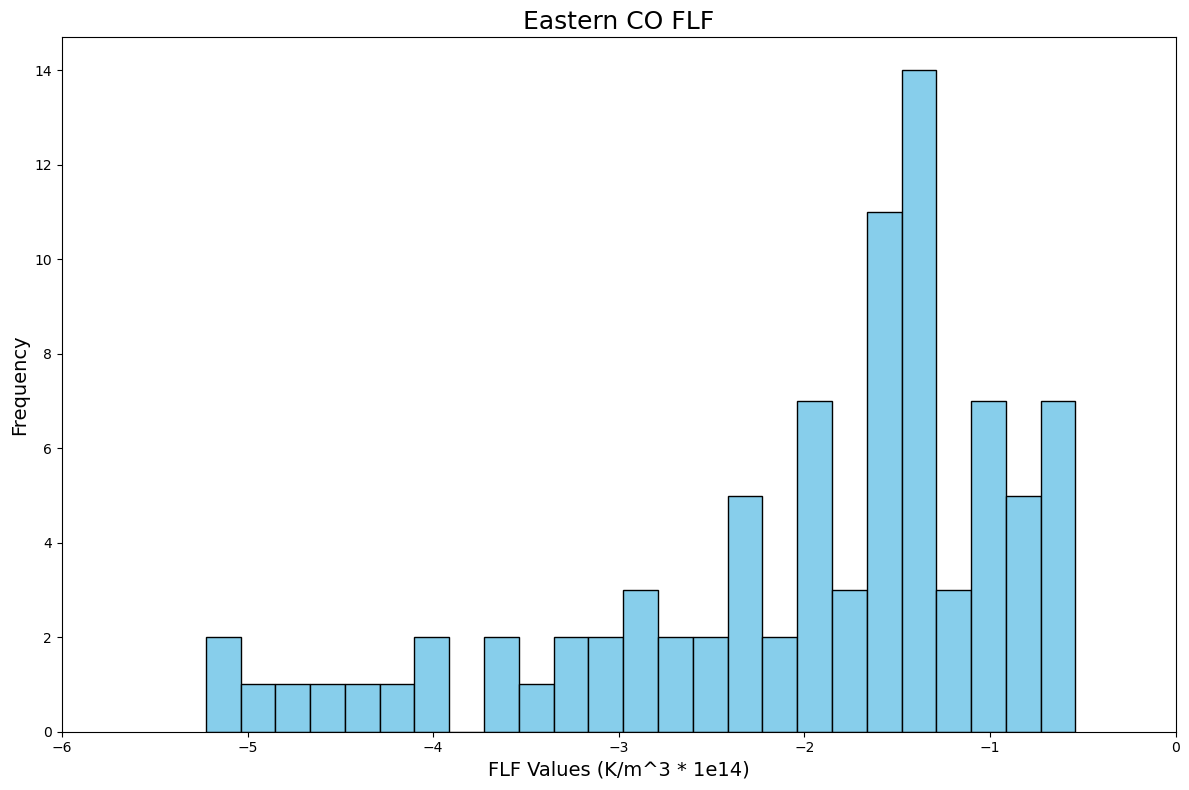

In [18]:
##Plot a histogram of all the step 4 divergence values for thresholding##

FLF_vals = FLF_ECO.copy().values.ravel() * 100  #Scale to plot
#FLF_clean = FLF_vals[~np.isnan(FLF_vals)]  #Take out NaNs

#Plotting time#
fig, ax = plt.subplots(1, figsize=(12, 8))

#FLF values in Eastern CO domain#
ax.hist(FLF_vals, bins=25, color='skyblue', edgecolor='black')
ax.set_title('Eastern CO FLF', fontsize=18)
ax.set_xlabel('FLF Values (K/m^3 * 1e14)', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_xlim([-6.0,0])  #-0.5

plt.tight_layout() 
plt.show()